In [38]:
import pandas as pd 
import matplotlib.pyplot as plt
import random
from sktime.forecasting.naive import NaiveForecaster
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_absolute_error, mean_squared_error

import numpy as np

random.seed(30)

df = pd.read_csv("data/us_change.csv", index_col=0)
print(df.columns)  # Lista todas as colunas disponíveis
df

Index(['Quarter', 'Consumption', 'Income', 'Production', 'Savings',
       'Unemployment'],
      dtype='object')


,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970 Q1,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970 Q2,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970 Q3,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970 Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971 Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...,...
194,2018 Q2,0.983112,0.661825,1.117424,-2.723974,0.0
195,2018 Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
196,2018 Q4,0.356512,0.695142,0.948148,5.031337,0.2
197,2019 Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


In [39]:
def convert_to_period(quarter):
    """
    Function to convert a string to a pandas period object. 
    Checks if the input is a string in the form '2019 Q1' or already a Period.
    """
    if isinstance(quarter, pd.Period):
        return quarter
    year, quarter_str = quarter.split()
    year = int(year)
    quarter = int(quarter_str[-1])
    return pd.Period(year=year, quarter=quarter, freq='Q')

df['Quarter'] = df['Quarter'].apply(convert_to_period)

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    """
    Função para calcular o MASE (Mean Absolute Scaled Error).
    """
    naive_forecast = np.roll(y_train, 1)[1:]  # Série atrasada para o erro naive
    mae_naive = mean_absolute_error(y_train[1:], naive_forecast)
    mae_model = mean_absolute_error(y_true, y_pred)
    return mae_model / mae_naive

Aplicando o modelo

In [40]:

# Configurar a coluna 'Quarter' como índice
df.set_index('Quarter', inplace=True)

# Escolher a coluna a ser prevista
y = df["Consumption"]

# Dividir os dados em treino e teste
train_size = int(len(y) * 0.8)
y_train, y_test = y[:train_size], y[train_size:]

# Criar o horizonte de previsão (fh)
fh = np.arange(1, len(y_test) + 1)  # Definir horizonte de previsão

# Criar e ajustar o modelo
forecaster = NaiveForecaster(strategy="last")  # Estratégia pode ser 'last', 'mean', ou 'drift'
forecaster.fit(y_train)

# Prever valores
y_pred = forecaster.predict(fh)

# Avaliar o modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mase = mean_absolute_scaled_error(y_test, y_pred, y_train)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Scaled Error (MASE): {mase}")

Mean Absolute Error (MAE): 1.0071672410592745
Root Mean Squared Error (RMSE): 1.0541747703354698
Mean Absolute Scaled Error (MASE): 1.6475436908741796


Plotando os resultados:

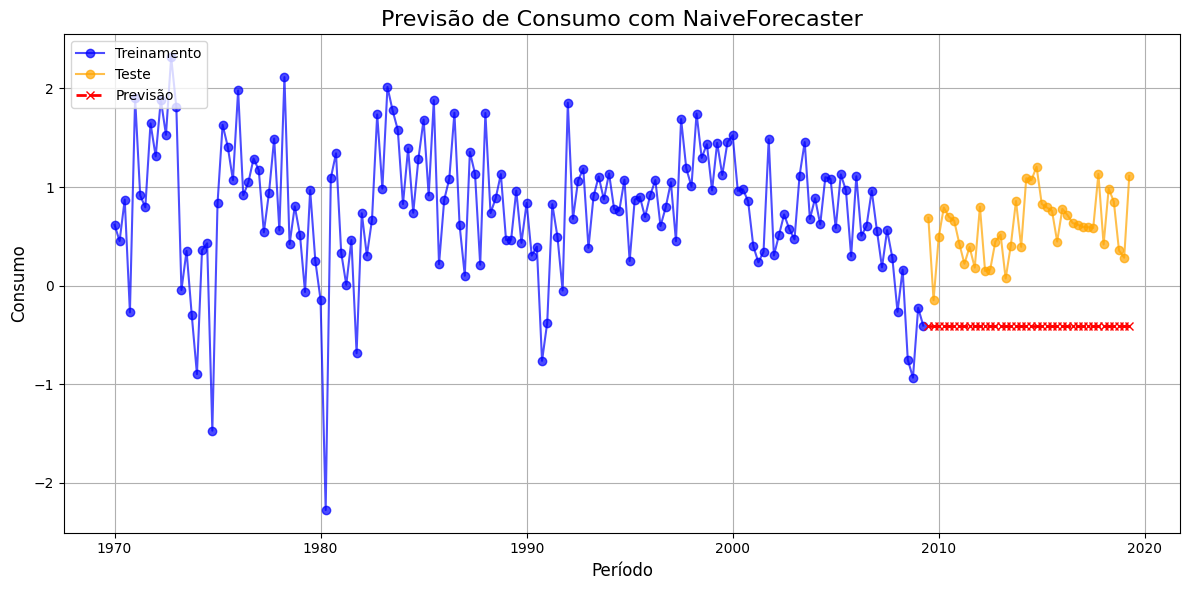

In [41]:
y_train.index = y_train.index.to_timestamp()
y_test.index = y_test.index.to_timestamp()
y_pred.index = y_test.index  # Garantir que y_pred tenha o mesmo índice


plt.figure(figsize=(12, 6))

# Plotar a série de treinamento
plt.plot(
    y_train.index,
    y_train,
    label='Treinamento',
    color='blue',
    linestyle='-',
    marker='o',
    alpha=0.7
)

# Plotar a série de teste
plt.plot(
    y_test.index,
    y_test,
    label='Teste',
    color='orange',
    linestyle='-',
    marker='o',
    alpha=0.7
)

# Plotar a previsão
plt.plot(
    y_test.index,
    y_pred,
    label='Previsão',
    color='red',
    linestyle='--',
    marker='x',
    linewidth=2
)

# Melhorar visualização
plt.title('Previsão de Consumo com NaiveForecaster', fontsize=16)
plt.xlabel('Período', fontsize=12)
plt.ylabel('Consumo', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()
